In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns 
import xgboost as xgb
from sklearn.model_selection import train_test_split
import spacy
from sklearn.neighbors import KNeighborsClassifier
from spacy import displacy
from gensim.similarities.annoy import AnnoyIndexer
from sklearn.tree import DecisionTreeClassifier
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
import nltk
from sklearn.datasets import fetch_20newsgroups
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import matplotlib.gridspec as gridspec
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

In [2]:
df = pd.read_csv('../input/iba-ml1-final-project/train.csv')
df.head()

,Id,Age,Review_Title,Review,Pos_Feedback_Cnt,Division,Department,Product_Category,Rating,Recommended
0,17274,34,Cute fall/holiday top,Love this top! the quality is magnificent and ...,1,General,Tops,Blouses,5,1
1,5921,35,NaN,NaN,0,General,Tops,Blouses,5,1
2,16479,40,Disappointed,"Sleeves were tight, was difficult to put on ?....",15,General,Tops,Blouses,2,0
3,1925,28,Gorgeous detailing,I never write reviews but this clothe is so fa...,3,General Petite,Clothes,Clothes,5,1
4,5691,39,Cute and comfortable tee!,Love this tshirt! casual but can be clotheed u...,0,General,Tops,Knits,5,1


## Deal with missing value imputations (more detailed version is in EDA notebook)

In [3]:
df['Product_Category'] = df['Product_Category'].fillna(value=df['Product_Category'].mode()[0])
df['Department'] = df['Department'].fillna(value=df['Department'].mode()[0])
df['Division'] = df['Division'].fillna(value=df['Division'].mode()[0])
df['Review'] = df['Review'].fillna(value='nan')
df['Review_Title'] = df['Review_Title'].fillna(value='nan')

In [4]:
df['Rating'] = df['Rating'].apply(lambda s: str(s))
df['Recommended'] = df['Recommended'].apply(lambda s: str(s))

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df['Review']).toarray()
labels = df.Rating
labelz = df.Recommended

In [11]:
df.shape

(14091, 10)

In [12]:
df = pd.read_csv('../input/iba-ml1-final-project/train.csv')
df.head()

,Id,Age,Review_Title,Review,Pos_Feedback_Cnt,Division,Department,Product_Category,Rating,Recommended
0,17274,34,Cute fall/holiday top,Love this top! the quality is magnificent and ...,1,General,Tops,Blouses,5,1
1,5921,35,NaN,NaN,0,General,Tops,Blouses,5,1
2,16479,40,Disappointed,"Sleeves were tight, was difficult to put on ?....",15,General,Tops,Blouses,2,0
3,1925,28,Gorgeous detailing,I never write reviews but this clothe is so fa...,3,General Petite,Clothes,Clothes,5,1
4,5691,39,Cute and comfortable tee!,Love this tshirt! casual but can be clotheed u...,0,General,Tops,Knits,5,1


In [13]:
df['Product_Category'] = df['Product_Category'].fillna(value=df['Product_Category'].mode()[0])
df['Department'] = df['Department'].fillna(value=df['Department'].mode()[0])
df['Division'] = df['Division'].fillna(value=df['Division'].mode()[0])
df['Review'] = df['Review'].fillna(value='nan')
df['Review_Title'] = df['Review_Title'].fillna(value='nan')

In [14]:
df['Rating'] = df['Rating'].apply(lambda s: str(s))
# df['Recommended'] = df['Recommended'].apply(lambda s: str(s))

In [15]:
msk = np.random.rand(len(df)) < 0.8
train_df = df[msk]
test_df = df[~msk]

In [67]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from scipy import stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

In [17]:
df['Review']

0        Love this top! the quality is magnificent and ...
1                                                      nan
2        Sleeves were tight, was difficult to put on ?....
3        I never write reviews but this clothe is so fa...
4        Love this tshirt! casual but can be clotheed u...
                               ...                        
14086    The pattern and fabric on this clothe are very...
14087    Like the previous reviewer stated, it's more l...
14088    This sweater is so lovely.. i like the fact th...
14089    I just love this top, it has a flattering cut,...
14090    This sweater is a dull off white color. it loo...
Name: Review, Length: 14091, dtype: object

In [52]:
sdf = df['Review_Title'] + ' ||| ' + df['Review']
sdf

0        Cute fall/holiday top ||| Love this top! the q...
1                                              nan ||| nan
2        Disappointed ||| Sleeves were tight, was diffi...
3        Gorgeous detailing ||| I never write reviews b...
4        Cute and comfortable tee! ||| Love this tshirt...
                               ...                        
14086    Too flowy ||| The pattern and fabric on this c...
14087    Soft, snuggly and cute ||| Like the previous r...
14088    Gorgeous! ||| This sweater is so lovely.. i li...
14089    Really versatile! ||| I just love this top, it...
14090    nan ||| This sweater is a dull off white color...
Length: 14091, dtype: object

In [73]:
X.reshape(-1, 1).shape

(14091, 1)

In [74]:
X = sdf.values
y1 = df['Rating']
y2 = df['Recommended']

rund = RandomUnderSampler()
X_rund, y_rund = rund.fit_resample(X.reshape(-1, 1), y2)

X_train, X_test, y_train, y_test = train_test_split(X_rund, y_rund)

In [76]:
Counter(y_rund)

Counter({0: 2501, 1: 2501})

In [75]:
VOCAB_SIZE = 20000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(X_train)

In [55]:
model = tf.keras.models.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),  # VOCAB_SIZE + 1 (1 for padding token)
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [56]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 1)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/10
331/331 [==============================] - 12s 22ms/step - loss: 0.4724 - accuracy: 0.8334 - val_loss: 0.2643 - val_accuracy: 0.8828
Epoch 2/10
331/331 [==============================] - 6s 17ms/step - loss: 0.2056 - accuracy: 0.9156 - val_loss: 0.2539 - val_accuracy: 0.8933
Epoch 3/10
331/331 [==============================] - 5s 16ms/step - loss: 0.1551 - accuracy: 0.9431 - val_loss: 0.2896 - val_accuracy: 0.8981
Epoch 00003: early stopping


In [77]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 1)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/10
118/118 [==============================] - 7s 26ms/step - loss: 0.2196 - accuracy: 0.9185 - val_loss: 0.2284 - val_accuracy: 0.9153
Epoch 2/10
118/118 [==============================] - 2s 19ms/step - loss: 0.1396 - accuracy: 0.9559 - val_loss: 0.2053 - val_accuracy: 0.9305
Epoch 3/10
118/118 [==============================] - 2s 16ms/step - loss: 0.1217 - accuracy: 0.9625 - val_loss: 0.2304 - val_accuracy: 0.9241
Epoch 00003: early stopping


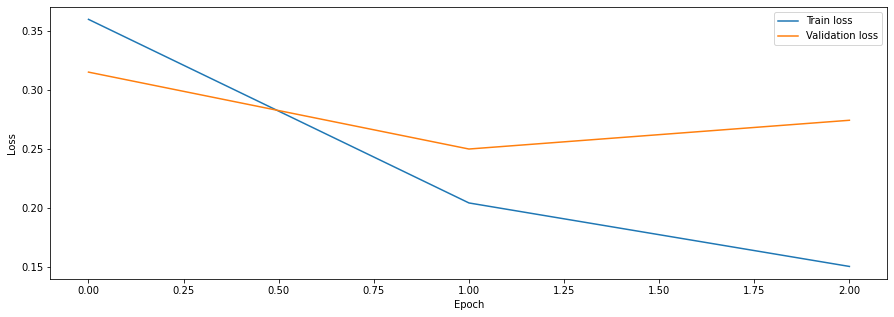

In [31]:
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

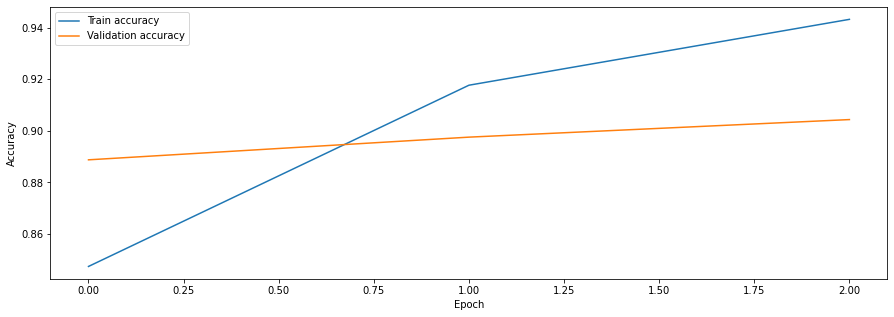

In [32]:
plt.figure(figsize=(15, 5))
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [93]:
labenc = LabelEncoder()
labenc.fit(y1)
encoded_Y = labenc.transform(y1)
dummy_y = np_utils.to_categorical(encoded_Y)

In [94]:
X = df['Review_Title'] + ' ||| ' + df['Review']
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y)

In [95]:
model1 = tf.keras.models.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),  # VOCAB_SIZE + 1 (1 for padding token)
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [96]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 0)
history = model1.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/30
331/331 [==============================] - 10s 18ms/step - loss: 1.2764 - accuracy: 0.5620 - val_loss: 0.9534 - val_accuracy: 0.6233
Epoch 2/30
331/331 [==============================] - 5s 16ms/step - loss: 0.8711 - accuracy: 0.6330 - val_loss: 0.8990 - val_accuracy: 0.6460
Epoch 3/30
331/331 [==============================] - 5s 16ms/step - loss: 0.7931 - accuracy: 0.6644 - val_loss: 0.8549 - val_accuracy: 0.6284
Epoch 4/30
331/331 [==============================] - 5s 16ms/step - loss: 0.7067 - accuracy: 0.7057 - val_loss: 0.8537 - val_accuracy: 0.6557
Epoch 5/30
331/331 [==============================] - 5s 15ms/step - loss: 0.6533 - accuracy: 0.7325 - val_loss: 0.8962 - val_accuracy: 0.6375
Epoch 00005: early stopping


In [90]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 1)
history = model1.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/30
331/331 [==============================] - 9s 18ms/step - loss: 0.7230 - accuracy: 0.6999 - val_loss: 0.8928 - val_accuracy: 0.6338
Epoch 2/30
331/331 [==============================] - 5s 15ms/step - loss: 0.6694 - accuracy: 0.7308 - val_loss: 0.9381 - val_accuracy: 0.6336
Epoch 00002: early stopping


In [45]:
test_df = pd.read_csv('../input/iba-ml1-final-project/test.csv')
test_df.head()

,Id,Age,Review_Title,Review,Pos_Feedback_Cnt,Division,Department,Product_Category
0,21403,53,Magnificent clothe!,"In contrast to the other reviewer, i love this...",4,General,Clothes,Clothes
1,22553,51,Shapeless tent,I tried this on in the store and it was huge. ...,2,General,Clothes,Clothes
2,17436,59,Versatile and then some,"I thought this was a fun piece to have, but di...",1,General,Bottoms,Trousers
3,4293,48,So simple but so cute!,I bought the multi-color stripe and it is ador...,1,General,Clothes,Clothes
4,20149,46,Magnificent simple tank,The wide strap style is very flattering. this ...,0,Initmates,Intimate,Layering


In [46]:
test_df.isna().sum()

Id                     0
Age                    0
Review_Title        1451
Review               342
Pos_Feedback_Cnt       0
Division               3
Department             3
Product_Category       3
dtype: int64

In [47]:
test_df['Product_Category'] = test_df['Product_Category'].fillna(value=test_df['Product_Category'].mode()[0])
test_df['Department'] = test_df['Department'].fillna(value=test_df['Department'].mode()[0])
test_df['Division'] = test_df['Division'].fillna(value=test_df['Division'].mode()[0])
test_df['Review'] = test_df['Review'].fillna(value='nan')
test_df['Review_Title'] = test_df['Review_Title'].fillna(value='nan')

In [ ]:
test_df.isna().sum()

In [48]:
recommended_predicted = model.predict_classes(test_df['Review_Title'] + ' | ' + test_df['Review'])
np.unique(recommended_predicted, return_counts=True)

rating_predicted = model1.predict_classes(test_df['Review'])
np.unique(rating_predicted, return_counts=True)

submission = pd.read_csv('../input/iba-ml1-final-project/sample_submission.csv')

submission['Rating'] = rating_predicted
submission['Recommended'] = recommended_predicted

submission.to_csv('submission_551.csv', index=False)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [99]:
recommended_predicted = model.predict_classes(test_df['Review_Title'] + ' ||| ' + test_df['Review'])
np.unique(recommended_predicted, return_counts=True)

rating_predicted = model1.predict_classes(test_df['Review_Title'] + ' ||| ' + test_df['Review'])
np.unique(rating_predicted, return_counts=True)

submission = pd.read_csv('../input/iba-ml1-final-project/sample_submission.csv')

submission['Rating'] = rating_predicted
submission['Recommended'] = recommended_predicted

submission.to_csv('submission_554x.csv', index=False)

In [92]:
stats.spearmanr(rating_predicted, recommended_predicted)

SpearmanrResult(correlation=0.7168650460233847, pvalue=0.0)

In [100]:
# X
stats.spearmanr(rating_predicted, recommended_predicted)

SpearmanrResult(correlation=0.724247552157243, pvalue=0.0)